# The Orienteering Problem

## Risoluzione tramite algoritmo genetico

### Valerio Domenico Conte M63001606

## Import delle librerie

In [1]:
import random
import math
import time

from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt

## Lettura dei dati dell'istanza

In [2]:
#path = "op_tmax_60.txt"
path = "set_66_1_120.txt"

file = open(path, "r")

rules = file.readline().split("\t")

Tmax = int(rules[0])
P = int(rules[1])

positions = []
S = []

for line in file:
    x, y, score = line.split("\t")
    positions.append((float(x), float(y)))
    S.append(int(score))
    
file.close()

last_node = positions.pop(1)
positions.append(last_node)

last_score = S.pop(1)
S.append(last_score)
    
def getDistanceMatrix(positions):
    distance_matrix = []
    
    for item1 in positions:
        tmp_list = []
        for item2 in positions:
            tmp_distance = math.sqrt((item1[0]-item2[0])**2+(item1[1]-item2[1])**2)     
            tmp_list.append(tmp_distance)
        distance_matrix.append(tmp_list)
    return distance_matrix

distance_map = getDistanceMatrix(positions)

## Creazione di individui e popolazione

In [3]:
# Il numero di geni degli individui è pari al numero di nodi meno 2
IND_SIZE = len(S) - 2

# Il primo e l'ultimo nodo sono fissi per questo li sottraiamo dal numero di geni
# Memorizziamo le loro posizioni per poterli usare nel calcolo delle distanze in seguito
start_node = 0
end_node = len(S) - 1

# Creazione delle classi di fitness e individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Creazione del toolbox per la definizione degli operatori evolutivi
toolbox = base.Toolbox()

toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Valutazione della funzione di fitness

In [4]:
def evalOP(individual):
    path = []
    
    for i in range(len(individual)):
        path.append(individual[i] + 1)
    
    distance = distance_map[start_node][path[0]]
    
    if distance > Tmax:
        return 0,
    
    score = S[path[0]]
    
    for gene1, gene2 in zip(path[0:-1], path[1:]):        
        distance += distance_map[gene1][gene2]
        
        if distance > Tmax:
            return 0,
        
        score += S[gene2]
        
    distance += distance_map[path[-1]][end_node]
    
    if distance > Tmax:
        return 0,

    return score,

toolbox.register("evaluate", evalOP)

## Operatori genetici e di selezione

In [5]:
# Funzione di crossover (accoppiamento/riproduzione)
def cxVariableLen(ind1, ind2):
    size1 = len(ind1)
    size2 = len(ind2)
    
    min_size = min(size1, size2)
    
    cxpoint = random.randint(0, min_size - 1)

    child1_genes = ind1[:cxpoint] + ind2[cxpoint:]
    child2_genes = ind2[:cxpoint] + ind1[cxpoint:]
    
    # Assicuriamoci che i figli siano sequenze di nodi unici
    child1_genes = fix_child(child1_genes)
    child2_genes = fix_child(child2_genes)
    
    # Crea nuovi individui
    child1 = creator.Individual(child1_genes)
    child2 = creator.Individual(child2_genes)
    
    # Aggiorna gli individui originali
    ind1[:] = child1
    ind2[:] = child2
    
    return ind1, ind2

# Metodo ausiliario per la correzione degli individui figli
def fix_child(child_genes):
    seen = set()
    
    fixed_child_genes = [x for x in child_genes if not (x in seen or seen.add(x))]
    
    return fixed_child_genes

# Funzione di mutazione
def mutVariableLen(individual, prob_pop, prob_swap):
    if random.random() < prob_pop:
        if len(individual) > 0:
            # Rimozione di un gene casuale
            random_index = random.randint(0, len(individual) - 1)
            individual.pop(random_index)
            
            # Rimozione del gene finale
            # individual.pop()
    else:
        if len(individual) < IND_SIZE:
            new_node = random.randint(0, IND_SIZE - 1)
            
            # Aggiunta del gene nuovo in una posizione casuale
            random_index = random.randint(0, len(individual))
        
            if new_node not in individual:
                # Aggiunta del gene alla fine della lista
                #individual.append(new_node)
                individual.insert(random_index, new_node)
                            
            
    if random.random() < prob_swap:    
        # Swap di due geni scelti casualmente
        index1, index2 = random.sample(range(len(individual)), 2)
        individual[index1], individual[index2] = individual[index2], individual[index1]
        
    return individual,

#prob_pop = 1/Tmax
prob_pop = 0.45
prob_swap = 0.8

toolbox.register("mate", cxVariableLen)
toolbox.register("mutate", mutVariableLen, prob_pop=prob_pop, prob_swap=prob_swap)
toolbox.register("select", tools.selTournament, tournsize=3)

## Esecuzione dell'algoritmo

In [6]:
random.seed(Tmax)

start_time = time.time()

population = toolbox.population(n=200)

ngen = 500
cxpb = 0.7
#mutpb = 0.05
mutpb = 0.04

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

end_time = time.time()

best_ind = tools.selBest(final_population, 1)[0]

print(f"Fitness migliore: {best_ind.fitness.values[0]}")
print(f"Tempo di calcolo: {end_time - start_time}")

final_solution = []
final_solution.append(start_node)

for i in range(len(best_ind)):
    final_solution.append(best_ind[i] + 1)

final_solution.append(end_node)

print(f"Soluzione migliore: {final_solution}")

Fitness migliore: 880.0
Tempo di calcolo: 1.4050579071044922
Soluzione migliore: [0, 62, 55, 39, 58, 49, 41, 59, 34, 33, 25, 3, 18, 9, 17, 26, 12, 6, 31, 48, 56, 64, 63, 40, 32, 8, 16, 15, 22, 65]


## Visualizzazione del percorso

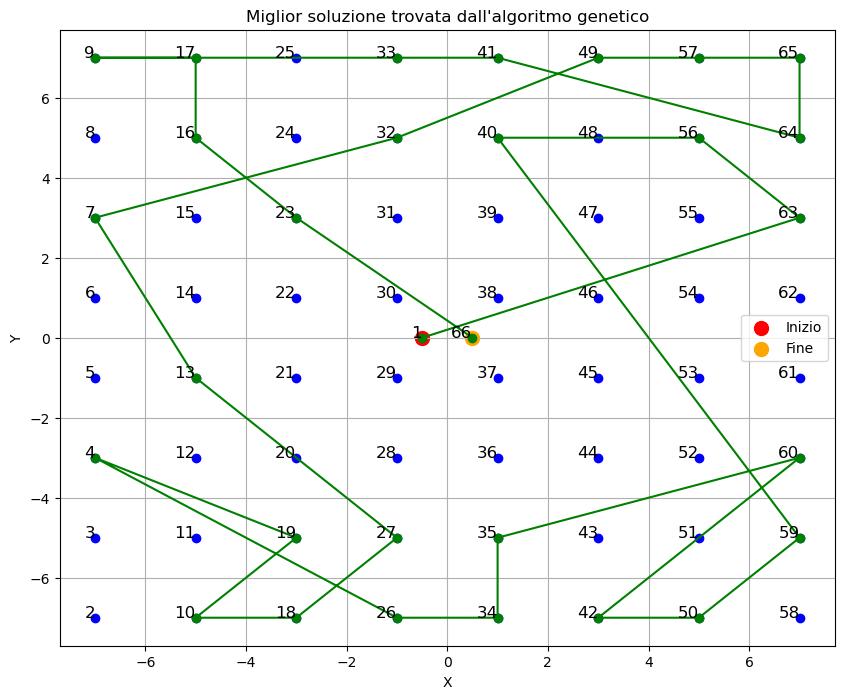

In [7]:
%matplotlib inline

def plot_path(node_positions, path):
    # Estrarre le coordinate dei nodi nel percorso
    x = [node_positions[i][0] for i in path]
    y = [node_positions[i][1] for i in path]

    plt.figure(figsize=(10, 8))
    plt.scatter(*zip(*node_positions), c='blue')
    
    # Annotare i nodi con le loro etichette
    for idx, (x_pos, y_pos) in enumerate(node_positions):
        plt.text(x_pos, y_pos, str(idx+1), fontsize=12, ha='right')
    
    # Disegnare il percorso
    plt.plot(x, y, linestyle='-', marker='o', color='green')

    # Evidenziare l'inizio e la fine del percorso
    plt.scatter(node_positions[path[0]][0], node_positions[path[0]][1], c='red', s=100, label='Inizio')
    plt.scatter(node_positions[path[-1]][0], node_positions[path[-1]][1], c='orange', s=100, label='Fine')
    
    plt.title("Miglior soluzione trovata dall'algoritmo genetico")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

# Eseguire la funzione per disegnare il percorso
plot_path(positions, final_solution)